# Check times
Mohamed identified some missing time stamps in the Canadian daily flow files. While investigating, I discovered the missing daily data for the US flow gauges is severely overestimated.

Causes:
1. Missing time stamps are days for which we have no observations. Somehow these NaNs got dropped somewhere in the processing chain. Here we add them back in.
2. The US missing values were overestimated because in certain cases we downloaded three sets of daily data: `00060_00001` (daily max), `00060_00002` (daily min), and `00060_00003` (daily mean). We've correctly used the daily mean when writing to netcdf, but erroneously included the max and min columns in the "missing value" count.

Procedure:
Loop over all basins and:
- For each flow file (daily, hourly)
    - Check if the number of time steps in the file is correct (all consecutive time steps are present)
        - If not, add and fill everything with NaN
    - Check if the number of missing data matches what we have in the metadata file

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr

In [2]:
# Data location
cs_main_folder = Path("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload")

In [3]:
cs_update_folder = Path("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload-updates/")

In [4]:
cs_meta = pd.read_csv(cs_update_folder / "camels-spat-metadata.csv")

## Confirm that the updates folder has all the files we expect

In [7]:
for ix,row in cs_meta.iterrows():
    scale = row.subset_category
    cntry = row.Country
    statn = row.Station_id
    
    # construct paths
    daily_path  = cs_update_folder / 'observations' / scale / 'obs-daily'  / f'{cntry}_{statn}_daily_flow_observations.nc'
    hourly_path = cs_update_folder / 'observations' / scale / 'obs-hourly' / f'{cntry}_{statn}_hourly_flow_observations.nc'

    # check if files exist
    if not daily_path.exists():
        print(f"{daily_path.name} missing in updates folder")
    if not hourly_path.exists():
        print(f"{hourly_path.name} missing in updates folder")

Everything appears to be there. Start processing.

## Process all files

In [7]:
def compare_datasets(ds1: xr.Dataset, ds2: xr.Dataset, max_plots: int = 10, 
                     title='', save_path=''):
    """
    Compare variables in two xarray datasets using subplots.

    Special cases:
    - time_bnds: splits into left/right bounds
    - q_obs_data_quality: handles string/categorical values
    - Handles differing time coordinates across datasets

    Parameters:
        ds1, ds2 : xarray.Dataset
        max_plots : int

    Returns:
        matplotlib.figure.Figure
    """
    var_names = list(ds1.data_vars.keys())
    plot_vars = []

    for var in var_names:
        if var == "time_bnds":
            plot_vars.extend(["time_bnds_left", "time_bnds_right"])
        elif var == "q_obs":
            plot_vars.append("q_obs")         # regular q_obs plot
            plot_vars.append("q_obs_diff")    # extra difference plot
        elif var == "q_obs_data_quality":
            plot_vars.append("q_obs_data_quality")
            plot_vars.append("q_obs_data_quality_diff")
        else:
            plot_vars.append(var)

    plot_vars = plot_vars[:max_plots]
    n_plots = len(plot_vars)

    ncols = 2
    nrows = (n_plots + 1) // 2

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3))
    axes = axes.flatten()

    for i, var in enumerate(plot_vars):
        ax = axes[i]

        # Handle time_bnds (left or right)
        if var.startswith("time_bnds"):
            bnd_idx = 0 if "left" in var else 1
            x1 = ds1["time"].values
            y1 = ds1["time_bnds"].isel(nbnds=bnd_idx).values
            x2 = ds2["time"].values
            y2 = ds2["time_bnds"].isel(nbnds=bnd_idx).values

            ax.plot(x1, y1, label="Dataset 1")
            ax.plot(x2, y2, label="Dataset 2", linestyle="--")
            ax.set_title(f"time_bnds ({'left' if bnd_idx == 0 else 'right'})")

        # Handle q_obs_data_quality (categorical strings)
        elif var == "q_obs_data_quality":
            x1 = ds1["time"].values
            x2 = ds2["time"].values
            vals1 = ds1[var].values.astype(str)
            vals2 = ds2[var].values.astype(str)

            unique_vals = sorted(set(vals1) | set(vals2))
            label_to_int = {label: i for i, label in enumerate(unique_vals)}
            y1 = [label_to_int[v] for v in vals1]
            y2 = [label_to_int[v] for v in vals2]

            ax.scatter(x1, y1, label="Dataset 1", marker='.', s=1)
            ax.scatter(x2, y2, label="Dataset 2", marker='.', s=1)
            ax.set_yticks(list(label_to_int.values()))
            ax.set_yticklabels(unique_vals)
            ax.set_title(var)

        elif var == "q_obs_diff":
            # Align q_obs on overlapping time for diff plot
            q1, q2 = xr.align(ds1["q_obs"], ds2["q_obs"], join="inner")
            time = q1["time"].values
            diff = (q2 - q1).values
        
            ax.plot(time, diff, label="ds2 - ds1", color="purple")
#            ax.axhline(0, color="gray", linestyle="--", linewidth=1)
            ax.set_title("q_obs difference")
            ax.set_ylabel("Difference")
            ax.legend()

        elif var == "q_obs_data_quality_diff":
            # Align the arrays on time
            q1, q2 = xr.align(ds1["q_obs_data_quality"], ds2["q_obs_data_quality"], join="inner")
            
            # Convert NaNs to empty strings
            q1_clean = q1.fillna("").astype(str)
            q2_clean = q2.fillna("").astype(str)
        
            # Compute difference flags
            diff_flags = (q1_clean != q2_clean).astype(int).values
            x = q1["time"].values
        
            # Stem plot of differences
            ax.stem(x, diff_flags, basefmt=" ", use_line_collection=True)
            ax.set_ylim(-0.1, 1.2)
            ax.set_yticks([0, 1])
            ax.set_yticklabels(["Same", "Different"])
            ax.set_title("q_obs_data_quality difference")
            ax.grid(True)

        # All other variables
        else:
            da1 = ds1[var]
            da2 = ds2[var]
            x1 = ds1["time"].values if "time" in da1.dims else np.arange(da1.shape[0])
            x2 = ds2["time"].values if "time" in da2.dims else np.arange(da2.shape[0])

            ax.plot(x1, da1.values, label="Dataset 1")
            ax.plot(x2, da2.values, label="Dataset 2", linestyle="--")
            ax.set_title(var)

        ax.legend()
        ax.grid(True)

    # Remove any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title)
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=100, bbox_inches='tight')
        plt.close(fig)
    return

In [5]:
# Create a new output folder so we can easily share changed files with FRDR
cs_update_folder2 = Path("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload-updates-2/")
cs_update_folder2.mkdir(exist_ok=True)

cs_update_figs = Path("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload-updates-2-FIGURES/")
cs_update_figs.mkdir(exist_ok=True)

In [6]:
# Create a new metadata file
meta_update = cs_meta.copy()

In [152]:
needs_update = []
num_missing = []

for ix,row in cs_meta.iterrows():
    scale = row.subset_category
    cntry = row.Country
    statn = row.Station_id
    
    # construct paths
    daily_middle  = f'observations/{scale}/obs-daily'
    hourly_middle = f'observations/{scale}/obs-hourly' 
    daily_path  = cs_update_folder/daily_middle/f'{cntry}_{statn}_daily_flow_observations.nc'
    hourly_path = cs_update_folder/hourly_middle/f'{cntry}_{statn}_hourly_flow_observations.nc'

    # --- Check for missing timestamps
    for file,freq in zip([daily_path, hourly_path],
                         ['D','H']):
        ds = xr.open_dataset(file)

        # Get number of actual time stamps
        current_datetimes = ds['time'].values

        # Get expected number of timestamps
        expected_datetimes = pd.date_range(start=current_datetimes[0], 
                                           end=current_datetimes[-1], 
                                           freq=freq)

        # Check
        if len(current_datetimes) < len(expected_datetimes):
            print(f"Missing timestamps in {file.name}")
            needs_update.append(file)
            num_missing.append(len(expected_datetimes) - len(current_datetimes))

            if freq == 'D':

                # Reindex
                ds_new = ds.reindex(time=expected_datetimes)

                # Create new timebounds
                left_bounds  = expected_datetimes
                right_bounds = expected_datetimes + pd.Timedelta(days=1)
                
                ds_new = ds_new.assign(time_bnds=(['nbnds','time'],
                                                  np.array([left_bounds.values, right_bounds.values])))
                
                ds_new.time_bnds.attrs['long_name'] = 'start and end points of each time interval'
                ds_new.time_bnds.attrs['time_zone'] = ds.time_bnds.attrs['time_zone']

                # Set quality of missing values to NaN (more precise: keep only values where Qobs is not NaN)
                ds_new['q_obs_data_quality'] = ds_new['q_obs_data_quality'].where(ds_new['q_obs'].notnull())

                # Fill the other variables with zeros to match their descriptions
                for var in ds_new.data_vars:
                    if 'q_obs_is' in var:
                        ds_new[var] = ds_new[var].where(ds_new['q_obs'].notnull(), other=0)

                # Check all timestamps are consecutive
                new_datetimes = ds_new['time'].values
                assert (new_datetimes == expected_datetimes).all(), f"Non-consecutive dates after reindex"

                # Create a comparison figure
                compare_datasets(ds, ds_new, title=file.name, 
                                 save_path=cs_update_figs/file.name.replace('nc','png'))

                # Output
                des = cs_update_folder2 / daily_middle
                des.mkdir(exist_ok=True, parents=True)
                ds_new.to_netcdf(des/file.name)
                
                # Shuffle files
                ds.close()
                ds_new.close()
                ds = ds_new # so that code below can always use 'ds'

            elif freq == 'H':
                print(f"Hourly updates not implemented yet")

        # Update missing values
        missing_vals = ds['q_obs'].isnull().sum().values
        if freq == 'D':
            meta_update.loc[ix, 'flow_obs_missing_daily'] = missing_vals
        elif freq == 'H':
            meta_update.loc[ix, 'flow_obs_missing_hourly'] = missing_vals


Missing timestamps in CAN_01AP006_daily_flow_observations.nc
Missing timestamps in CAN_01BV004_daily_flow_observations.nc
Missing timestamps in CAN_01CC005_daily_flow_observations.nc
Missing timestamps in CAN_01DL001_daily_flow_observations.nc
Missing timestamps in CAN_01DP004_daily_flow_observations.nc
Missing timestamps in CAN_01ED005_daily_flow_observations.nc
Missing timestamps in CAN_02AB014_daily_flow_observations.nc
Missing timestamps in CAN_02AB021_daily_flow_observations.nc
Missing timestamps in CAN_02AC001_daily_flow_observations.nc
Missing timestamps in CAN_02AC002_daily_flow_observations.nc
Missing timestamps in CAN_02AD010_daily_flow_observations.nc
Missing timestamps in CAN_02AE001_daily_flow_observations.nc
Missing timestamps in CAN_02CA002_daily_flow_observations.nc
Missing timestamps in CAN_02CF008_daily_flow_observations.nc
Missing timestamps in CAN_02CF011_daily_flow_observations.nc
Missing timestamps in CAN_02CG003_daily_flow_observations.nc
Missing timestamps in CA

In [153]:
len(needs_update) # was: 724

724

Manually inspected all summary plots. Summary of visual checks:
- CAN_05OC019: has 1 different value in quality flags: 'B' in old, nan in new. Checks show that Qobs in old is nan, so presumably a minor processing error in HYDAT that either the Qobs value is missing or the quality flag is incorrectly provided
- CAN_08OA005: same
- CAN_10LC003: same, on 13 days
- USA_01123000: same, on 22 days
- USA_01187300: same, on 12 days
- USA_03281100: same, on 1 day
- USA_04074950: same, on 12 days
- USA_04296000: same, on 11 days
- Plus various other ones. Pattern is always the same for these: a handful of (P)rovisional values towards the end of the timeseries are under ice-affected conditions and nan. The difference comes from the ice-affected condition being set to '' but because Qobs is nan anyway this doesn't matter.

### Check missing values outcomes

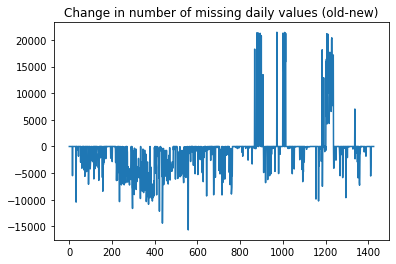

In [172]:
plt.plot(cs_meta['flow_obs_missing_daily']-meta_update['flow_obs_missing_daily'])
plt.title('Change in number of missing daily values (old-new)');

As expected:
- in the Canadian cases (ix < 765) we have more missing values because we inserted a whole bunch of empty timestamps
- in the USA cases (ix > 765) we have a mix because (1) we inserted empty time stamps, but (2) in certain cases we also corrected the double (or triple) counting of missing values that accidentally included the daily min and daily max columns

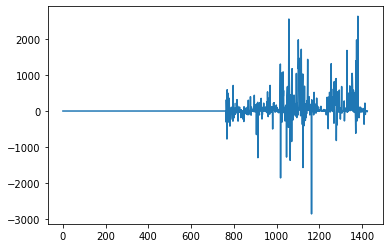

In [155]:
plt.plot(cs_meta['flow_obs_missing_hourly']-meta_update['flow_obs_missing_hourly'])
plt.title('Change in number of missing hourly values (old-new)');

- Canadian gauges were recently updated after we added a decade or so of hourly values for each gauge. No change
- USA gauges are likely explained by the fact that we took several iterations to get the hourly averaging correct, and based the initial missing value counts on an earlier hourly averaging iteration. Some spot checks of the hourly CSV files that underpin the hourly netcdfs suggests the new counts are accurate.

In [175]:
# save the metadata to file
meta_update.to_csv(cs_update_folder2/"camels-spat-metadata.csv", index=False)

### DEV

In [133]:
# set up a known test case
cntry = 'USA' #'CAN'
statn = '04296000' #'05TG002'
scale = 'meso-scale' #'macro-scale' #
daily_middle  = f'observations/{scale}/obs-daily'
file = cs_update_folder/daily_middle/f'{cntry}_{statn}_daily_flow_observations.nc'
ds = xr.open_dataset(file)

In [134]:
freq = 'D'

In [135]:
# Get number of actual time stamps
current_datetimes = ds['time'].values

In [136]:
# Get expected number of timestamps
expected_datetimes = pd.date_range(start=current_datetimes[0], 
                                   end=current_datetimes[-1], 
                                   freq=freq)

In [137]:
# Check
if len(current_datetimes) < len(expected_datetimes):
    print(f"Missing timestamps")

Missing timestamps


In [138]:
# Reindex
ds_new = ds.reindex(time=expected_datetimes)

In [139]:
# Create new timebounds
left_bounds  = expected_datetimes
right_bounds = expected_datetimes + pd.Timedelta(days=1)

ds_new = ds_new.assign(time_bnds=(['nbnds','time'],
                                  np.array([left_bounds.values, right_bounds.values])))

ds_new.time_bnds.attrs['long_name'] = 'start and end points of each time interval'
ds_new.time_bnds.attrs['time_zone'] = ds.time_bnds.attrs['time_zone']

In [140]:
# Set quality of missing values to NaN (more precise: keep only values where Qobs is not NaN)
ds_new['q_obs_data_quality'] = ds_new['q_obs_data_quality'].where(ds_new['q_obs'].notnull())

In [141]:
# Fill the other variables with zeros to match their descriptions
for var in ds_new.data_vars:
    if 'q_obs_is' in var:
        ds_new[var] = ds_new[var].where(ds_new['q_obs'].notnull(), other=0)

In [142]:
# Check all timestamps are consecutive
new_datetimes = ds_new['time'].values
assert (new_datetimes == expected_datetimes).all(), f"Non-consecutive dates after reindex"

In [177]:
# prep output
des = cs_update_folder2 / daily_middle
des.mkdir(exist_ok=True, parents=True)

In [182]:
ds_new.to_netcdf(des/file.name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


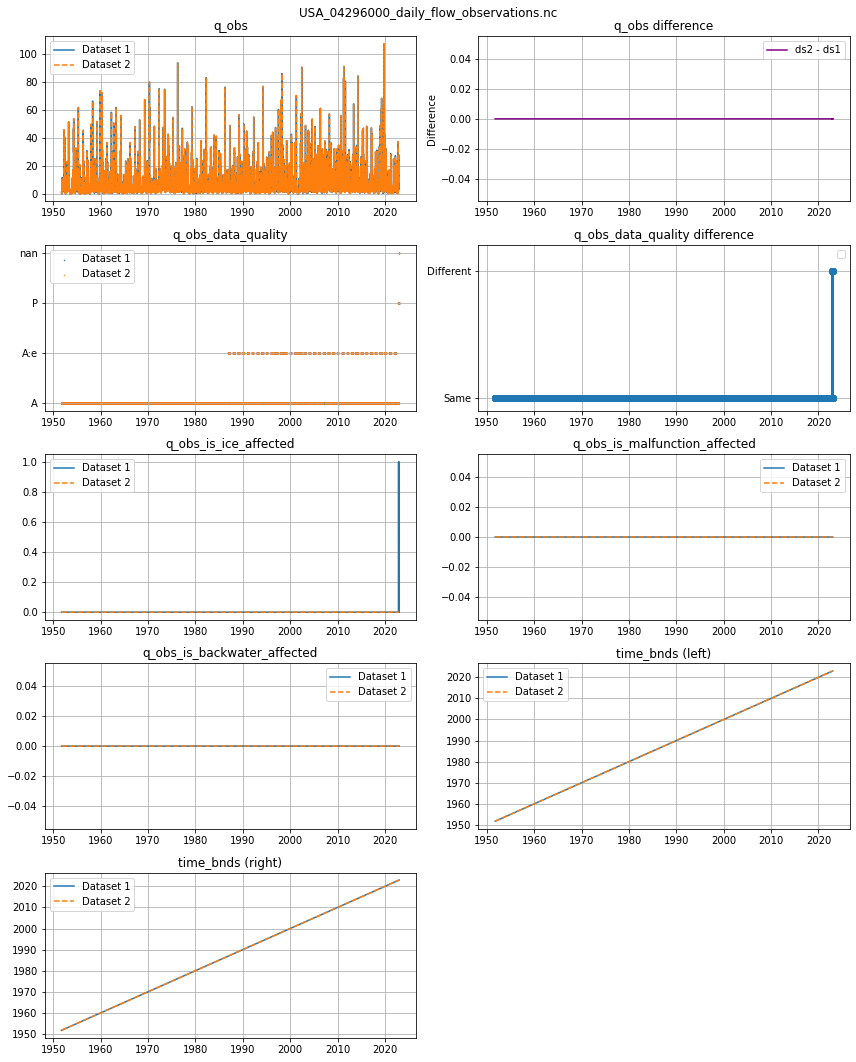

In [143]:
# Create a comparison figure
compare_datasets(ds, ds_new, title=file.name)#, 
                 #save_path=cs_update_figs/file.name.replace('nc','png'))

In [195]:
# Count missing values
missing_vals = ds_new['q_obs'].isnull().sum().values

In [197]:
if freq == 'D':
    meta_update.loc[ix, 'flow_obs_missing_daily'] = missing_vals
elif freq == 'H':
    meta_update.loc[ix, 'flow_obs_missing_hourly'] = missing_vals

In [144]:
# Align the arrays on time
q1, q2 = xr.align(ds["q_obs_data_quality"], ds_new["q_obs_data_quality"], join="inner")

# Convert NaNs to empty strings
q1_clean = q1.fillna("").astype(str)
q2_clean = q2.fillna("").astype(str)

# Compute difference flags
diff_flags = (q1_clean != q2_clean).astype(int).values

In [145]:
q1[diff_flags == 1]

<xarray.DataArray 'q_obs_data_quality' (time: 11)>
array(['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2022-11-21 2022-12-10 ... 2022-12-28
Attributes:
    standard_name:  quality_flag
    long_name:      data quality flag
    flag_values:    'A' 'A:e' 'P'
    flag_meanings:  'Approved, with unknown data grade code' 'Approved AND es...

In [146]:
q2[diff_flags == 1]

<xarray.DataArray 'q_obs_data_quality' (time: 11)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2022-11-21 2022-12-10 ... 2022-12-28
Attributes:
    standard_name:  quality_flag
    long_name:      data quality flag
    flag_values:    'A' 'A:e' 'P'
    flag_meanings:  'Approved, with unknown data grade code' 'Approved AND es...

In [147]:
ds['q_obs'].sel(time=q1[diff_flags == 1].time)

<xarray.DataArray 'q_obs' (time: 11)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2022-11-21 2022-12-10 ... 2022-12-28
Attributes:
    units:                m3 s-1
    long_name:            observed streamflow values
    cell_methods:         time:mean
    ancillary_variables:  'q_obs_is_ice_affected' 'q_obs_is_malfunction_affec...